In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from rdkit import Chem
from dfs_transformer.utils import Mol2Smiles, DFSCode2Graph, Graph2Mol, isValid, Smiles2DFSCode, DFSCode2Smiles, isValidMoleculeDFSCode
from dfs_transformer.utils import load_selfattn_wandb, load_selfattn_local
import os.path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dfs_transformer as dfs
import numpy as np
from ml_collections import ConfigDict
import yaml
import functools
import tqdm

Using backend: pytorch


In [2]:
pretrained_model = "r2r-noprop-2K"
force_download = False
if os.path.isdir("../../wandb/artifacts/%s"%pretrained_model) and not force_download:
    bert, cfg = load_selfattn_local("../../wandb/artifacts/%s"%pretrained_model)
else:
    bert, cfg = load_selfattn_wandb(pretrained_model, wandb_dir="../../wandb")

In [3]:
bert = bert.eval()

In [4]:
with open("../../config/selfattn/data/pubchem10K.yaml") as file:
    d = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

In [5]:
d

max_edges: 110
max_nodes: 110
molecular_properties: null
n_iter_per_split: 10
n_used: null
path: ./results/pubchem/noH/10K/
useDists: false
useHs: false
valid_path: ./results/pubchem/noH/validation/

In [6]:
d.no_features = cfg.data.no_features

In [7]:
collate_fn = functools.partial(dfs.collate_BERT, 
                               mode=cfg.training.mode, 
                               fraction_missing = cfg.training.fraction_missing,
                               use_loops=cfg.model.use_loops)

In [8]:
validset = dfs.PubChem('../.'+d.valid_path, max_nodes=d.max_nodes, max_edges=d.max_edges, noFeatures=d.no_features,
                   molecular_properties=d.molecular_properties, useDists=d.useDists, useHs=d.useHs)
validloader = DataLoader(validset, batch_size=100, shuffle=False, 
                         pin_memory=True, collate_fn=collate_fn, num_workers=0,
                         prefetch_factor=2)

100%|████████████████████████████████████| 9978/9978 [00:00<00:00, 10400.36it/s]


In [9]:
device = torch.device('cuda:%d'%0 if torch.cuda.is_available() else 'cpu')
to_cuda = functools.partial(dfs.utils_to_cuda, device=device)

In [10]:
bert = bert.to(device)

In [11]:
dfs_codes = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    dfs_codes += bert.fwd_code(data[0], features=not cfg.data.no_features)

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.06it/s]


In [22]:
valid_list = []
exception_counter = 0
for data in validset:
    try:
        valid_list += [isValid(Chem.MolFromSmiles(data.smiles))]
    except Exception as e:
        exception_counter += 1
        valid_list += [False]
valid = np.asarray(valid_list)
print(valid.sum()/len(valid), exception_counter)

1.0 0


In [27]:
valid_list = []
mols = []
same_list = []
for code, data in zip(dfs_codes, validset):
    try:
        valid_list += [isValidMoleculeDFSCode(code)]
    except Exception as e:
        valid_list += [False]
    try: 
        if valid_list[-1]:
            smiles_orig = Mol2Smiles(Chem.MolFromSmiles(data.smiles))
            smiles_rec = DFSCode2Smiles(code)
            same_list += [smiles_orig == smiles_rec]
            if np.random.rand()<0.05:
                mols += [Chem.MolFromSmiles(data.smiles)]
                mols += [Chem.MolFromSmiles(DFSCode2Smiles(code))]
    except Exception as e:
        print(e)
        print(Graph2Mol(*DFSCode2Graph(code)))
        print("----------------------")
valid = np.asarray(valid_list)
same = np.asarray(same_list)
print("%2.4f valid molecules"%((valid.sum()/len(valid))))
print("%2.4f of the valid molecules stayed the same"%(same.sum()/len(same)))

0.3330 valid molecules
0.3755 of the valid molecules stayed the same


/home/chrisw/.cache/pypoetry/virtualenvs/graph-transformer-9jPERXQ--py3.8/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


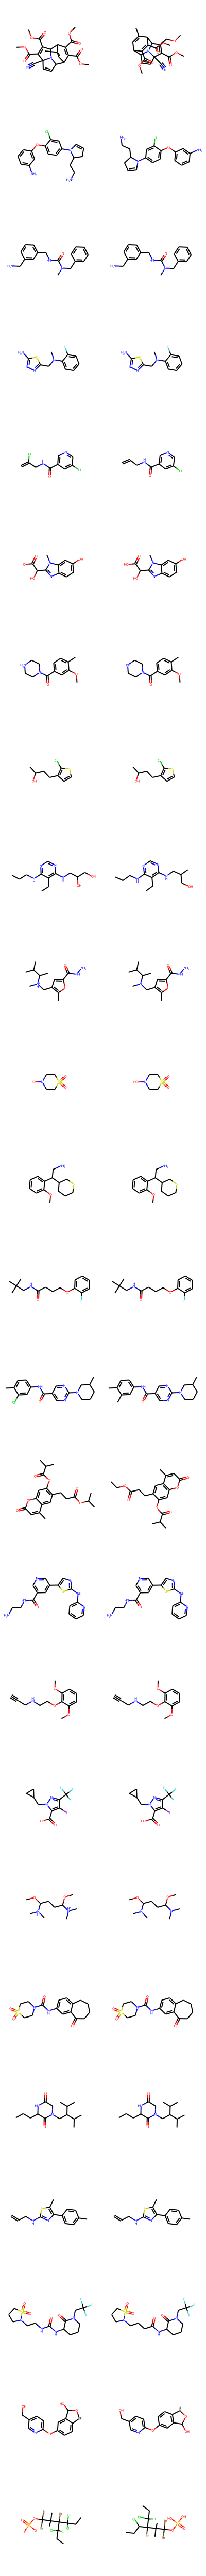

In [28]:
Chem.Draw.MolsToGridImage(mols, molsPerRow=2)

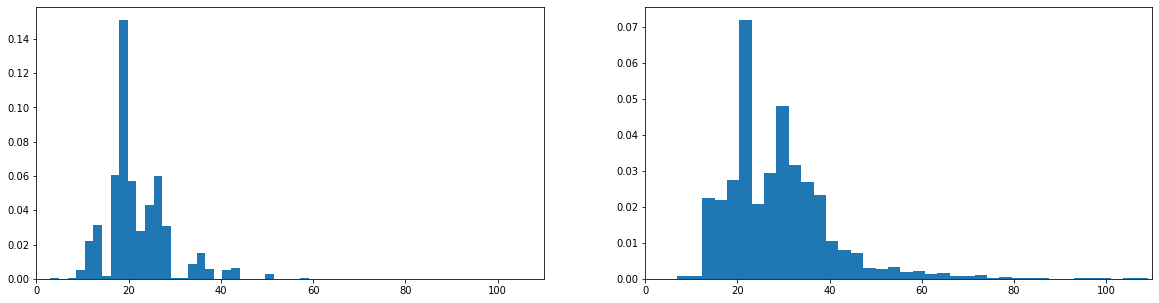

In [29]:
from matplotlib import pyplot as plt
lens = np.asarray([len(dfs_code) for dfs_code in dfs_codes])
plt.figure(figsize=(20,5))
plt.subplot(1,2,1).hist(lens[valid], bins='rice', density=True)
plt.xlim(0, 110)
plt.subplot(1,2,2).hist(lens[True^valid], bins='rice', density=True)
plt.xlim(0, 110)
plt.show()